## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

#### using local postgreSQL (football_db)

In [2]:
database_name = 'football_db'

In [3]:
conn = psycopg2.connect(f'dbname={database_name}')

In [4]:
cur = conn.cursor()
columns = ['League', 'Matches']

query = f"""
SELECT L.name, COUNT(*) as Count 
FROM match AS M
JOIN league AS L ON M.league_id = L.id
GROUP BY L.name
ORDER BY Count DESC
"""

cur.execute(query)
data = cur.fetchall()

In [5]:
df = pd.DataFrame(data, columns=columns)
df.head()

,League,Matches
0,England Premier League,3040
1,Spain LIGA BBVA,3040
2,France Ligue 1,3040
3,Italy Serie A,3017
4,Germany 1. Bundesliga,2448


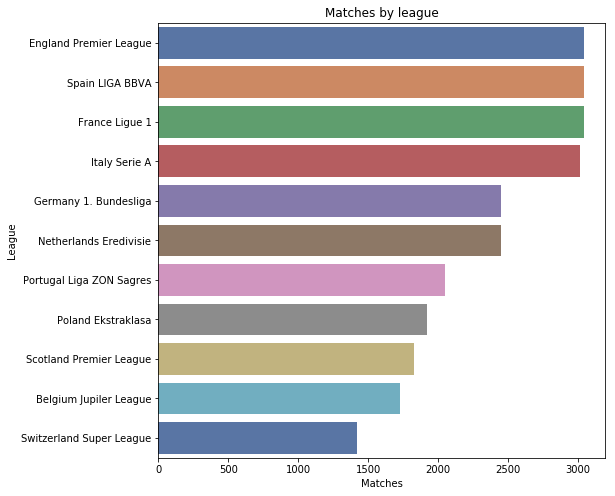

In [16]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(df['Matches'], df['League'], palette='deep')

plt.title("Matches by league")
plt.show()


In [7]:
cur = conn.cursor()

query = f"""
SELECT * 
FROM player AS P
JOIN player_attributes AS PA ON P.id = PA.id
"""

cur.execute(query)
data = cur.fetchall()

In [8]:
columns = [desc[0] for desc in cur.description]

In [9]:
player_info = pd.DataFrame(data, columns=columns)

In [10]:
player_info.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id,player_fifa_api_id,player_api_id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187.0,1,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146.0,2,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,162549,Aaron Doran,186170,1991-05-13,170.18,163.0,3,218353,505942,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198.0,4,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154.0,5,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [11]:
from math import pi

def showPlayerStats(name='Cristiano Ronaldo'):
# Players: 'Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Heung-Min Son'...
    player = player_info[player_info["player_name"] == name]
    cols = ['player_name','overall_rating', 'finishing', 
            'heading_accuracy', 'short_passing', 'dribbling', 
            'sprint_speed', 'shot_power', 'jumping', 'stamina',
            'strength', 'positioning', 'penalties', 'sliding_tackle']

    player = player[cols]
    player = player.groupby("player_name")[cols].mean().reset_index()

    plt.figure(figsize=(8,8))
    ax = plt.subplot(projection="polar")
    cats = list(player)[1:]
    N    = len(cats)

    mean_values = player_info.iloc[:,:].mean()
    mean_values = mean_values[cols]
    
    values = mean_values.drop("player_name").values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N)*2*pi for n in range(N)]
    angles += angles[:1]

    plt.xticks(angles[:-1],cats,color="r",size=7)
    plt.ylim([0,100])
    plt.plot(angles,values,color='r',linewidth=2,linestyle="solid")
    plt.fill(angles,values,color='r',alpha=1)

    values = player.loc[0].drop("player_name").values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N)*2*pi for n in range(N)]
    angles += angles[:1]

    plt.xticks(angles[:-1],cats,color="k",size=12)
    plt.ylim([0,100])
    plt.plot(angles,values,color='y',linewidth=3,linestyle="solid")
    plt.fill(angles,values,color='y',alpha=0.5)

    plt.gca().legend(('Average', name), bbox_to_anchor=(1, 0.5, 0.5, 0.5), loc=8)
    plt.title(name,color="b", fontsize=18)
    plt.subplots_adjust(wspace=.4,hspace=.4)


/Users/teo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


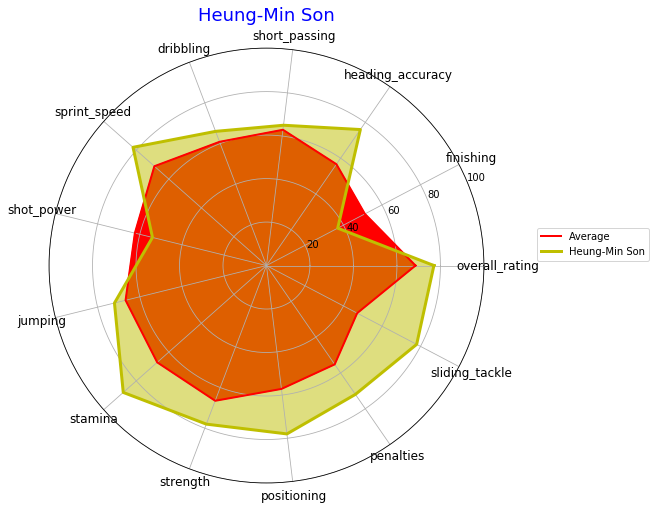

In [12]:
showPlayerStats('Heung-Min Son')

In [17]:
cur = conn.cursor()

query = f"""
SELECT T.team_long_name, SUM(games) games FROM
(SELECT home_team_api_id AS team_api_id, count(*) games
FROM match
WHERE home_team_goal > away_team_goal
GROUP BY home_team_api_id
UNION
SELECT away_team_api_id AS team_api_id, count(*) games
FROM match
WHERE home_team_goal < away_team_goal
GROUP BY away_team_api_id) AS TG
JOIN TEAM T ON T.team_api_id = TG.team_api_id
GROUP BY T.team_long_name
ORDER BY games DESC
"""

cur.execute(query)
data = cur.fetchall()


In [27]:
columns = ['team', 'wins']
team_df = pd.DataFrame(data, columns=columns)

In [28]:
team_df = team_df.head(10)

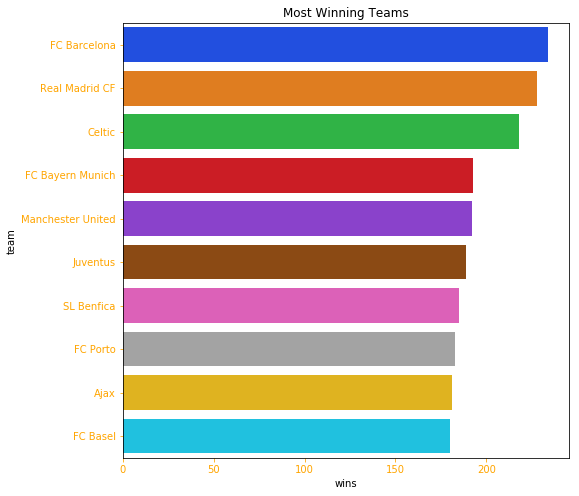

In [35]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(team_df['wins'], team_df['team'], palette='bright')

ax.tick_params(axis='x', colors='orange')
ax.tick_params(axis='y', colors='orange')

plt.title("Most Winning Teams")
plt.show()

